In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax

In [8]:
batch_size = 32
img_height = 224
img_width = 224
lr_rate = 1e-3
lr_mode = 'cos'
epochs = 13
data_dir = pathlib.Path(r'C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Train').with_suffix('')

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 537 files belonging to 6 classes.
Using 430 files for training.
Found 537 files belonging to 6 classes.
Using 107 files for validation.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


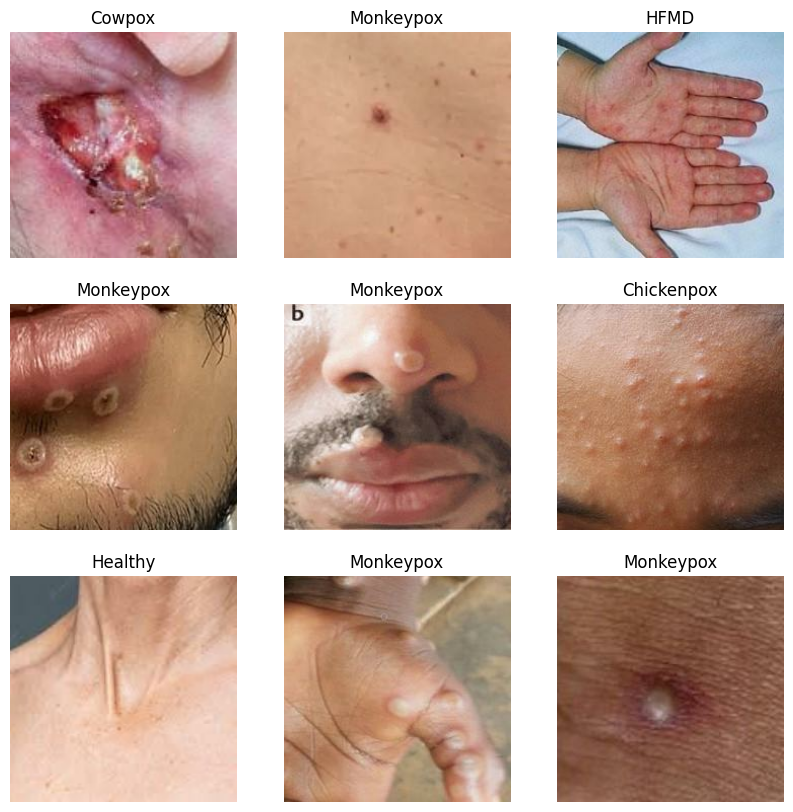

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.035025924 1.0


In [11]:
base_model = keras.applications.VGG16(
    weights='imagenet',                # Pre-trained on ImageNet
    input_shape=(img_width, img_height, 3),  # Input shape of your images
    include_top=False)     

In [12]:
base_model.trainable = False

In [13]:
inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(6)(x)

model = keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,207,366 (65.64 MB)

 Trainable params: 2,492,678 (9.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
plot_model(
    model,
    to_file="resnet_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=96
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [15]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback


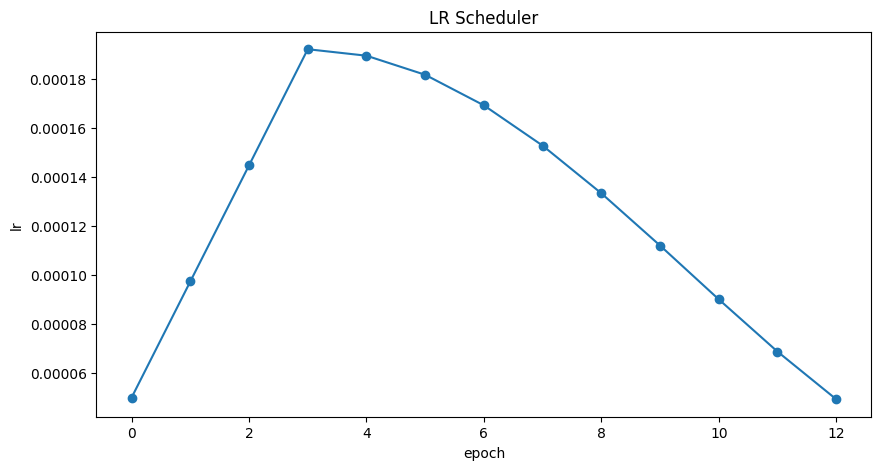

In [16]:
lr_cb = get_lr_callback(batch_size, mode=lr_mode, plot=True, epochs=epochs)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=train_ds)

Epoch 1/13


14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.2652 - loss: 2.6170 - val_accuracy: 0.6558 - val_loss: 0.9779 - learning_rate: 5.0000e-05
Epoch 2/13
14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.7470 - loss: 0.7034 - val_accuracy: 0.8233 - val_loss: 0.5186 - learning_rate: 9.7333e-05
Epoch 3/13
14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.8785 - loss: 0.3634 - val_accuracy: 0.9186 - val_loss: 0.2958 - learning_rate: 1.4467e-04
Epoch 4/13
14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.9317 - loss: 0.2342 - val_accuracy: 0.9558 - val_loss: 0.1516 - learning_rate: 1.9200e-04
Epoch 5/13
14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.9584 - loss: 0.1639 - val_accuracy: 0.8140 - val_loss: 0.4818 - learning_rate: 1.8936e-04
Epoch 6/13
14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.9087 - loss: 0.2556 - val_accuracy: 0.9140 - val_loss: 0.3248 - learning_rate: 1.8158e-04
Epoch 7/13
14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.9228 - loss: 0.2590 - 

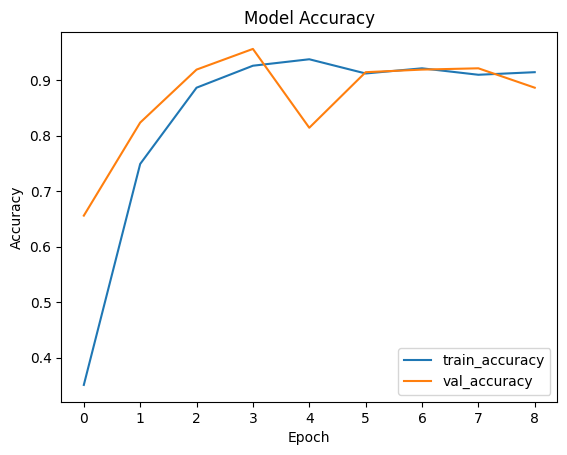

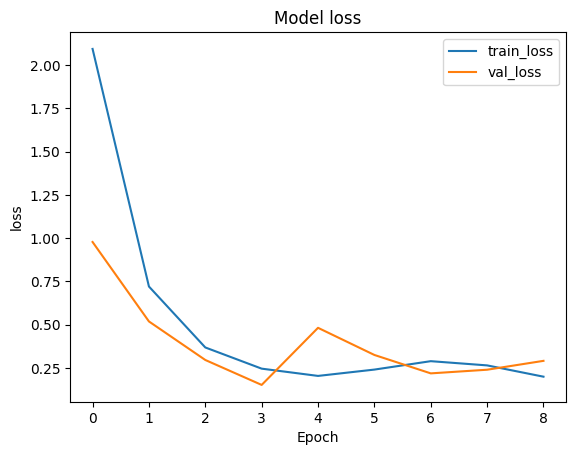

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [20]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 74 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6254 - loss: 1.7376


[1.8640445470809937, 0.5945945978164673]

In [21]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold2\Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 82 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7892 - loss: 0.6312


[0.5844782590866089, 0.8048780560493469]

In [22]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold3\Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 64 files belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8333 - loss: 0.6998


[0.6501896977424622, 0.828125]

In [23]:
test_data_dir = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold4\Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 81 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7834 - loss: 0.6510


[0.7580482363700867, 0.7777777910232544]

In [24]:
model.save('VGG16Mpox_model.keras')

In [25]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions =model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras

In [27]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.53      1.00      0.69         9
      Cowpox       0.68      1.00      0.81        13
        HFMD       0.93      0.93      0.93        15
     Healthy       0.89      0.89      0.89         9
     Measles       1.00      0.88      0.93         8
   Monkeypox       0.86      0.44      0.59        27

    accuracy                           0.78        81
   macro avg       0.82      0.86      0.81        81
weighted avg       0.82      0.78      0.77        81



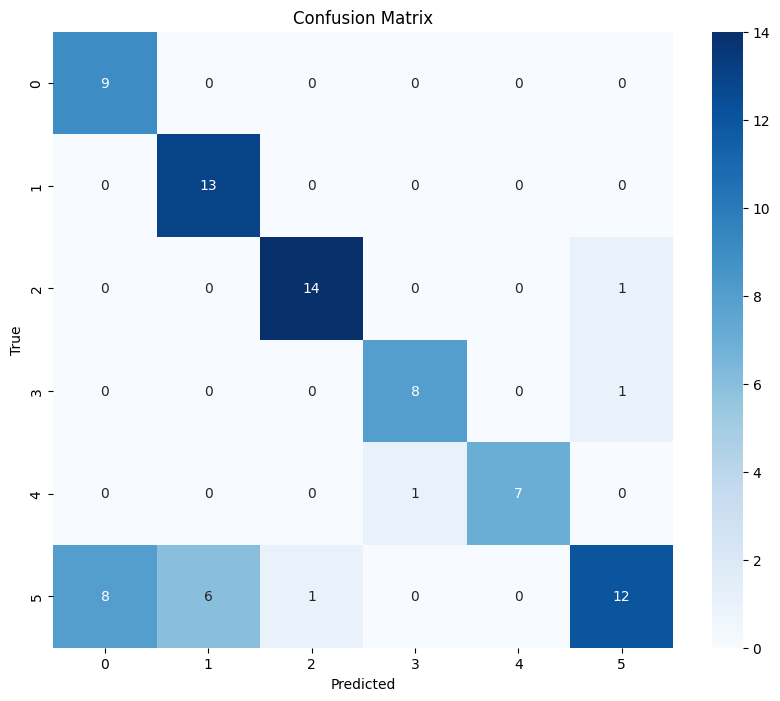

In [28]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [3]:
def predict_image(image_path, model, class_names):
    img = load_img(image_path)
    img = img.resize((img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    class_idx = np.argmax(y_pred, axis=1)[0]
    return class_names[class_idx]

In [4]:
loaded_model = tf.keras.models.load_model(r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\VGG16Mpox_model.keras", compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# prediction on custom images

img_path1 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Chickenpox\CHP_19_01.jpg"    # Chickenpox
img_path2 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Healthy\HEALTHY_98_01.jpg" # Healthy
img_path3 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Measles\MSL_23_01.jpg" # Measles
img_path4 = r"C:\Users\user\OneDrive\Desktop\MPOX Dataset\Original Images\FOLDS\fold1\Test\Cowpox\CWP_09_01.jpg" # Cowpox

In [16]:
print('Predicted Class name:', predict_image(img_path1, model, class_names))

print('Predicted Class name:', predict_image(img_path2, model, class_names))

print('Predicted Class name:', predict_image(img_path3, model, class_names))

print('Predicted Class name:', predict_image(img_path4, model, class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicted Class name: Cowpox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Predicted Class name: Measles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Predicted Class name: Chickenpox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Predicted Class name: Cowpox
